In [ ]:
%%capture
!pip install timm flash_attn einops

In [ ]:
%%bash
git clone https://github.com/AssemblyAI-Community/florence-2
mv florence-2/** .
rm -rf ./florence-2/

Cloning into 'florence-2'...


In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import copy
import torch
import utils
%matplotlib inline

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
model_id = "microsoft/Florence-2-large"
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().to(device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def run_example(task_prompt, image, text_input=None):
    prompt = task_prompt if text_input is None else f"{task_prompt} {text_input}"
    inputs = processor(text=prompt, images=image, return_tensors="pt")

    with torch.no_grad():  # Pour éviter les calculs inutiles de gradient
        generated_ids = model.generate(
            input_ids=inputs["input_ids"].to(device),
            pixel_values=inputs["pixel_values"].to(device),
            max_new_tokens=1024,
            early_stopping=True,
            do_sample=False,
            num_beams=3,
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        parsed_answer = processor.post_process_generation(
            generated_text,
            task=task_prompt,
            image_size=(image.width, image.height),
        )
    return parsed_answer

In [ ]:
path = "Test2.png"  # Assurez-vous que l'image est dans le répertoire courant
image = Image.open(path).convert("RGB")


In [ ]:
tasks = [
    utils.TaskType.CAPTION,
    utils.TaskType.DETAILED_CAPTION,
    utils.TaskType.MORE_DETAILED_CAPTION,
]

for task in tasks:
    results = run_example(task.value, image)
    print(f"{task.value}: {results}")

<CAPTION>: {'<CAPTION>': 'A black and white photo of a book with pictures of ancient Greek vases.'}
<DETAILED_CAPTION>: {'<DETAILED_CAPTION>': 'The image shows a page from a book with a black and white drawing of a group of people and a vase. The vase is decorated with intricate designs and the people in the drawing are depicted in a variety of poses. The text on the page provides further information about the vase and its contents.'}
<MORE_DETAILED_CAPTION>: {'<MORE_DETAILED_CAPTION>': "The image is a collage of six black and white illustrations. The illustrations are arranged in a grid-like pattern, with each illustration showing a different scene. \n\nThe first illustration on the top left shows a vase with a figure of a woman standing on a pedestal. The figure is wearing a long robe and a headdress, and is holding a staff in one hand and a book in the other. The woman appears to be in a meditative pose, with her eyes closed and a peaceful expression on her face. The second illustra

In [ ]:
# Tâche OCR simple
task = utils.TaskType.OCR
results = run_example(task.value, image)
print(f"Results for {task.value}: {results}")

# Tâche OCR avec région
task = utils.TaskType.OCR_WITH_REGION
results = run_example(task.value, image)
print(f"Results for {task.value}: {results}")

Results for <OCR>: {'<OCR>': 'DIONYSOJ/PACCHUS (IN PERIPERIA OCCIDENTIAL) 324-351\nDIONYSJ/PACCHUS(IN PERIEPERIA OCIDENTIALI) 352-507\n63\nBacchus (in per ocel) 3274\nBachus (ip per ocell) 364\nBaccus (p per ocl) 3292\nBachus (in pet) 3293\nBachuus (pin per oce) 324\nBuchus (pn pet) 0cel) 4247\nBachaus (n per (ocel) 365\nBochus (mn per oc) 3245\nBucachus (n pet) ocel: 3245.\nBuccus (nn per occ) 3145\nBacus (in pot) 0cc) 2.46\n'}
Results for <OCR_WITH_REGION>: {'<OCR_WITH_REGION>': {'quad_boxes': [[169.39651489257812, 31.687501907348633, 469.7185363769531, 31.687501907348633, 469.7185363769531, 43.51750183105469, 169.39651489257812, 43.51750183105469], [771.2815551757812, 29.15250015258789, 1071.603515625, 29.15250015258789, 1071.603515625, 40.98250198364258, 771.2815551757812, 40.98250198364258], [1185.7755126953125, 29.15250015258789, 1200.6676025390625, 29.15250015258789, 1200.6676025390625, 38.44750213623047, 1185.7755126953125, 38.44750213623047], [261.2304992675781, 250.5425109863

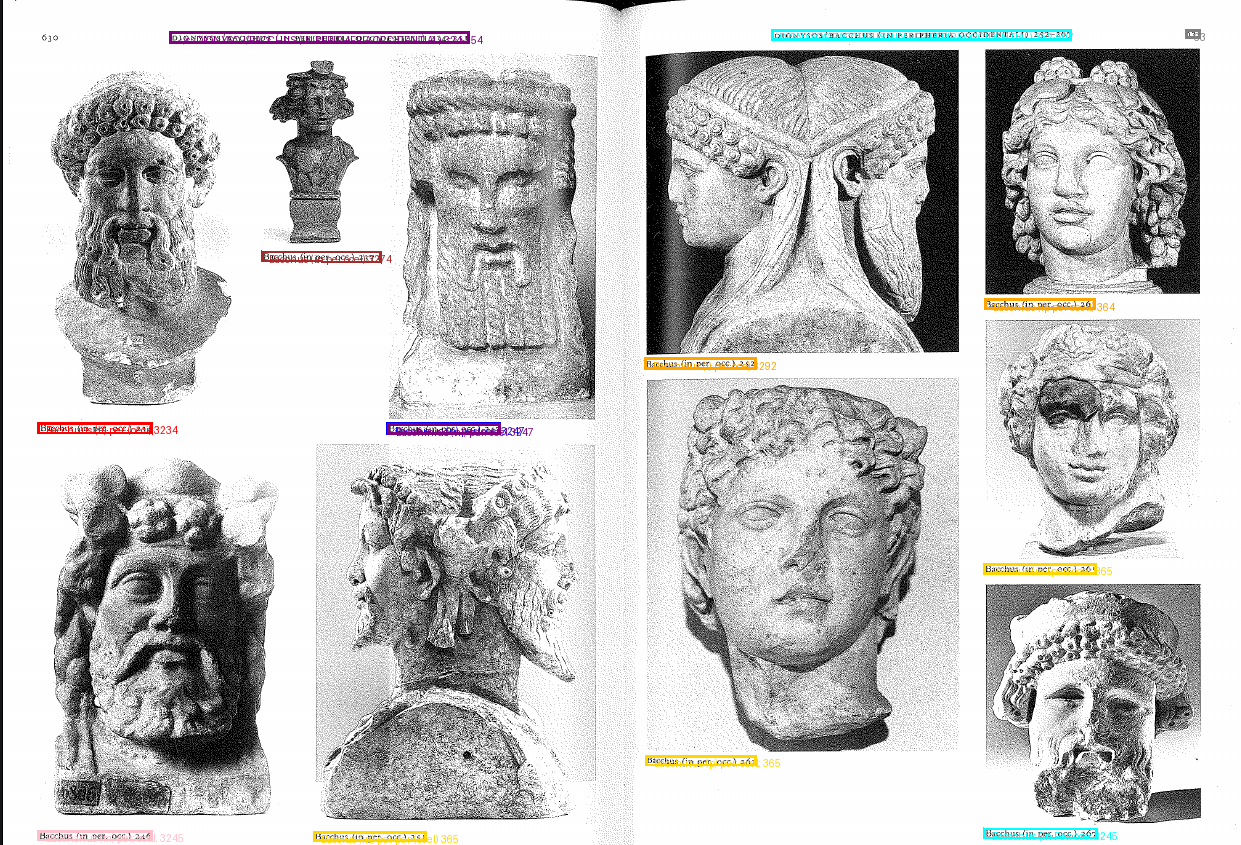

In [ ]:
image_copy = copy.deepcopy(image)  # Éviter de modifier l'image originale
utils.draw_ocr_bboxes(image_copy, results[task])

In [ ]:
# Créer un dictionnaire pour organiser les données
ocr_with_region_data = {}

# Extraire les quads (boîtes) et les labels
if '<OCR_WITH_REGION>' in results:
    quad_boxes = results['<OCR_WITH_REGION>']['quad_boxes']
    labels = results['<OCR_WITH_REGION>']['labels']

    for i, (box, label) in enumerate(zip(quad_boxes, labels)):
        # Créer un dictionnaire pour chaque entrée OCR avec ses coordonnées et le label
        ocr_with_region_data[f'Box_{i + 1}'] = {
            'coordinates': box,  # Coordonnées de la boîte (quad box)
            'label': label       # Label de la détection OCR
        }

# Afficher les résultats sous forme de dictionnaire
print("Données OCR_WITH_REGION (chaque box dans un dictionnaire séparé) :")
for key, value in ocr_with_region_data.items():
    print(f"{key}: {value}")

Données OCR_WITH_REGION (chaque box dans un dictionnaire séparé) :
Box_1: {'coordinates': [169.39651489257812, 31.687501907348633, 469.7185363769531, 31.687501907348633, 469.7185363769531, 43.51750183105469, 169.39651489257812, 43.51750183105469], 'label': '</s>DIONYSOJ/PACCHUS (IN PERIPHERIA OCCIDENTIAL) 324-354'}
Box_2: {'coordinates': [771.2815551757812, 29.15250015258789, 1071.603515625, 29.15250015258789, 1071.603515625, 40.98250198364258, 771.2815551757812, 40.98250198364258], 'label': 'DIONYSOS/PACCHRUS (UN PERIPERIRA OCCIDENTIAL) 352-507'}
Box_3: {'coordinates': [1185.7755126953125, 29.15250015258789, 1200.6676025390625, 29.15250015258789, 1200.6676025390625, 38.44750213623047, 1185.7755126953125, 38.44750213623047], 'label': '63'}
Box_4: {'coordinates': [261.2304992675781, 250.54251098632812, 381.6075134277344, 251.38751220703125, 381.6075134277344, 263.2174987792969, 261.2304992675781, 261.5274963378906], 'label': 'Bacchus (in per ocel) 3274'}
Box_5: {'coordinates': [984.7335

In [ ]:
tasks =  utils.TaskType.OBJECT_DETECTION,
for task in tasks:
    results = run_example(task.value, image)
    print(f"{task.value}: {results}")



<OD>: {'<OD>': {'bboxes': [[704.2675170898438, 445.7375183105469, 894.1405639648438, 665.4375], [88.73150634765625, 542.9125366210938, 243.85650634765625, 738.1075439453125], [430.00653076171875, 133.08750915527344, 557.8295288085938, 283.49749755859375], [1028.1685791015625, 657.83251953125, 1158.4735107421875, 787.9625244140625], [1023.2045288085938, 119.5675048828125, 1138.6175537109375, 253.92251586914062], [78.80350494384766, 128.8625030517578, 191.73451232910156, 261.5274963378906], [1030.6505126953125, 378.13751220703125, 1144.822509765625, 504.88751220703125], [667.0375366210938, 140.6925048828125, 760.112548828125, 248.00750732421875], [348.10052490234375, 541.2225341796875, 418.8375244140625, 644.3125], [679.447509765625, 385.7425231933594, 928.8885498046875, 668.8175048828125], [51.501502990722656, 71.40250396728516, 221.5185089111328, 269.13250732421875], [320.79852294921875, 461.7925109863281, 580.1675415039062, 820.072509765625], [675.7245483398438, 384.0525207519531, 931

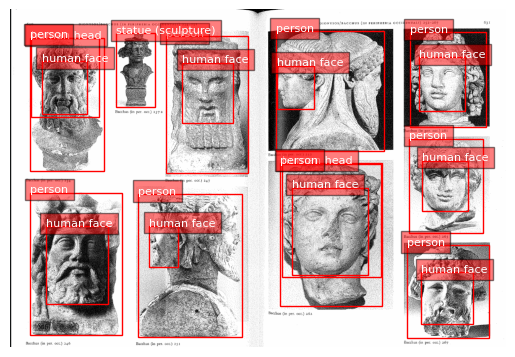

In [ ]:
image_copy = copy.deepcopy(image)  # Éviter de modifier l'image originale
utils.plot_bbox(results[task], image)

In [ ]:
# Créer un dictionnaire pour organiser les données
object_detection_data = {}

# Extraire les boîtes (bboxes) et les labels
if '<OD>' in results:
    bboxes = results['<OD>']['bboxes']
    labels = results['<OD>']['labels']

    for i, (bbox, label) in enumerate(zip(bboxes, labels)):
        # Créer un dictionnaire pour chaque entrée de détection avec ses coordonnées et le label
        object_detection_data[f'Box_{i + 1}'] = {
            'coordinates': bbox,  # Coordonnées de la boîte (bbox)
            'label': label        # Label de la détection d'objet
        }

# Afficher les résultats sous forme de dictionnaire
print("Données OBJECT_DETECTION (chaque box dans un dictionnaire séparé) :")
for key, value in object_detection_data.items():
    print(f"{key}: {value}")

Données OBJECT_DETECTION (chaque box dans un dictionnaire séparé) :
Box_1: {'coordinates': [704.2675170898438, 445.7375183105469, 894.1405639648438, 665.4375], 'label': 'human face'}
Box_2: {'coordinates': [88.73150634765625, 542.9125366210938, 243.85650634765625, 738.1075439453125], 'label': 'human face'}
Box_3: {'coordinates': [430.00653076171875, 133.08750915527344, 557.8295288085938, 283.49749755859375], 'label': 'human face'}
Box_4: {'coordinates': [1028.1685791015625, 657.83251953125, 1158.4735107421875, 787.9625244140625], 'label': 'human face'}
Box_5: {'coordinates': [1023.2045288085938, 119.5675048828125, 1138.6175537109375, 253.92251586914062], 'label': 'human face'}
Box_6: {'coordinates': [78.80350494384766, 128.8625030517578, 191.73451232910156, 261.5274963378906], 'label': 'human face'}
Box_7: {'coordinates': [1030.6505126953125, 378.13751220703125, 1144.822509765625, 504.88751220703125], 'label': 'human face'}
Box_8: {'coordinates': [667.0375366210938, 140.6925048828125, 